Dataset loader, preprocess

Label Mapping: {'(': 0, ')': 1, '+': 2, ',': 3, '-': 4, '0': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '9': 14, '=': 15, 'T': 16, 'X': 17, 'cos': 18, 'e': 19, 'f': 20, 'forward_slash': 21, 'i': 22, 'phi': 23, 'pi': 24, 'sin': 25, 'sum': 26, 'tan': 27, 'theta': 28, 'times': 29, 'w': 30, 'y': 31, 'z': 32}
Training set size: 193105
Validation set size: 41379
Test set size: 41381


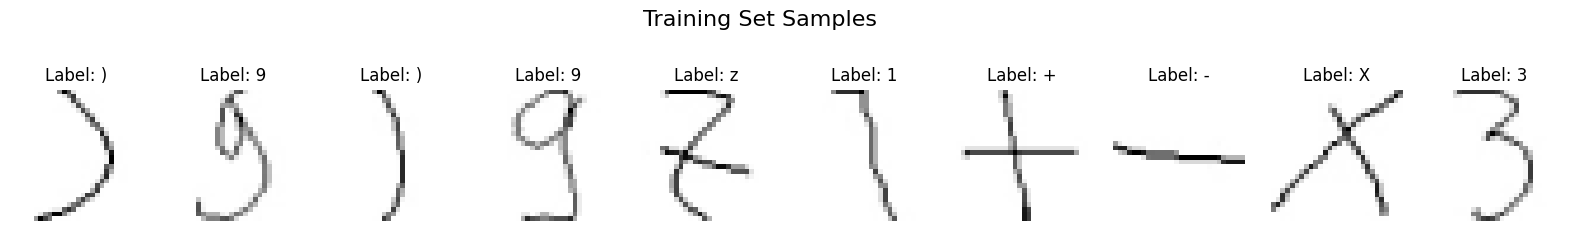

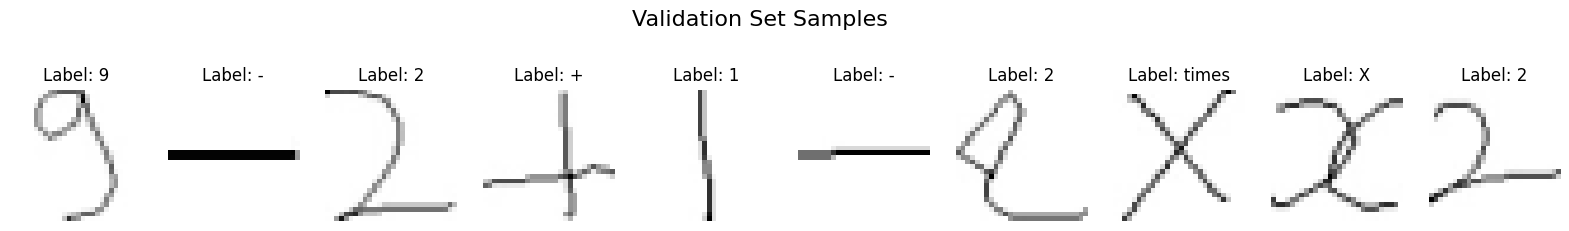

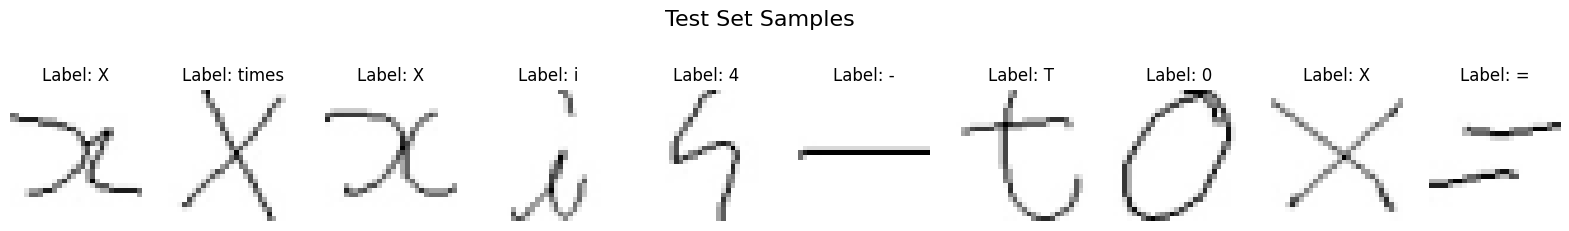

In [70]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to mean 0, std 1
])

# Path to dataset (update with your actual dataset folder path)
dataset_path = "D:/pynq/FinalProject/dataset"

# Load dataset using ImageFolder
dataset = ImageFolder(root=dataset_path, transform=transform)
int_to_char = {v: k for k, v in dataset.class_to_idx.items()}

# Create a mapping for labels
label_mapping = dataset.class_to_idx
print("Label Mapping:", label_mapping)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size  # Remaining samples for test set

torch.manual_seed(42)
# Split the dataset
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Print the number of items in each split
print("Training set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

# Create DataLoaders for each set
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Function to display 10 samples from any DataLoader
def show_samples(dataloader, title="Samples", dataset=dataset):
    class_names = dataset.classes  # Get the class names from ImageFolder
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, 10, figsize=(20, 3))
    fig.suptitle(title, fontsize=16)
    for i in range(10):
        ax = axes[i]
        ax.imshow(images[i].squeeze().numpy(), cmap='gray')
        ax.set_title(f"Label: {class_names[labels[i]]}")  # Map the numeric label to the class name
        ax.axis('off')
    plt.show()

# Show samples from each set
show_samples(train_loader, "Training Set Samples")
show_samples(val_loader, "Validation Set Samples")
show_samples(test_loader, "Test Set Samples")


Epoch 1/10


Validating: 100%|██████████| 1294/1294 [00:18<00:00, 70.67it/s]


Epoch 1 - Train Loss: 0.5092, Train Acc: 85.08%, Val Loss: 0.2030, Val Acc: 93.87%
Epoch 2/10


Validating: 100%|██████████| 1294/1294 [00:18<00:00, 70.96it/s]


Epoch 2 - Train Loss: 0.1749, Train Acc: 94.48%, Val Loss: 0.1529, Val Acc: 95.43%
Epoch 3/10


Validating: 100%|██████████| 1294/1294 [00:18<00:00, 69.68it/s]


Epoch 3 - Train Loss: 0.1358, Train Acc: 95.53%, Val Loss: 0.1651, Val Acc: 94.97%
Epoch 4/10


Validating: 100%|██████████| 1294/1294 [00:18<00:00, 71.44it/s]


Epoch 4 - Train Loss: 0.0893, Train Acc: 96.95%, Val Loss: 0.0987, Val Acc: 96.97%
Epoch 5/10


Validating: 100%|██████████| 1294/1294 [00:18<00:00, 71.50it/s]


Epoch 5 - Train Loss: 0.0808, Train Acc: 97.25%, Val Loss: 0.0937, Val Acc: 97.02%
Epoch 6/10


Validating: 100%|██████████| 1294/1294 [00:18<00:00, 69.41it/s]


Epoch 6 - Train Loss: 0.0763, Train Acc: 97.40%, Val Loss: 0.0907, Val Acc: 97.25%
Epoch 7/10


Validating: 100%|██████████| 1294/1294 [00:18<00:00, 69.65it/s]


Epoch 7 - Train Loss: 0.0705, Train Acc: 97.59%, Val Loss: 0.0885, Val Acc: 97.35%
Epoch 8/10


Validating: 100%|██████████| 1294/1294 [00:18<00:00, 68.36it/s]


Epoch 8 - Train Loss: 0.0697, Train Acc: 97.60%, Val Loss: 0.0875, Val Acc: 97.27%
Epoch 9/10


Validating: 100%|██████████| 1294/1294 [00:18<00:00, 71.62it/s]


Epoch 9 - Train Loss: 0.0692, Train Acc: 97.61%, Val Loss: 0.0870, Val Acc: 97.28%
Epoch 10/10


Validating: 100%|██████████| 1294/1294 [00:19<00:00, 68.09it/s]


Epoch 10 - Train Loss: 0.0685, Train Acc: 97.65%, Val Loss: 0.0873, Val Acc: 97.25%


Testing: 100%|██████████| 1294/1294 [00:12<00:00, 106.84it/s]

Final Test Loss: 0.0814, Test Acc: 97.31%
Final model saved as 'lenetV5.pth'.


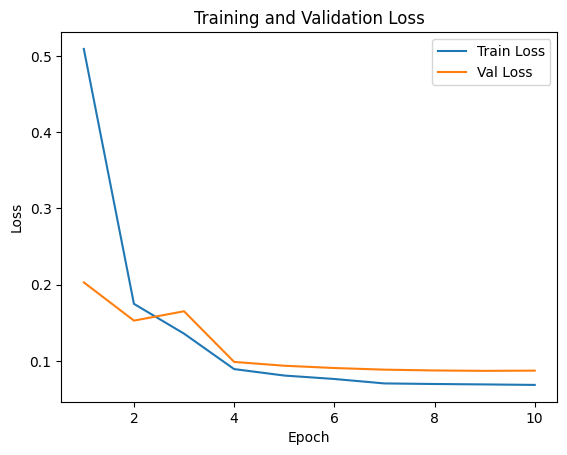

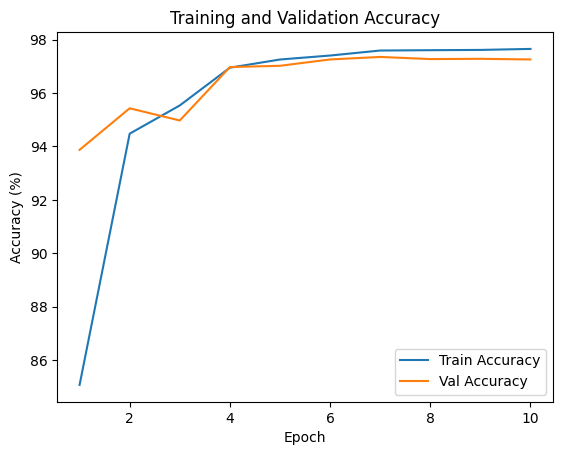

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.quantization as quant

class LeNet5(nn.Module):
    def __init__(self, num_classes=34):  # Adjust according to your dataset
        super(LeNet5, self).__init__()
        self.quant = torch.ao.quantization.QuantStub()  # QuantStub
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.reshape(-1, 16 * 5 * 5)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        x = self.dequant(x)
        return x

# Initialize the model
model = LeNet5(num_classes=34)  # Adjust if not using a 94-class dataset

# Set the model to evaluation mode before applying QAT
model.eval()

# Set the quantization backend to x86
torch.backends.quantized.engine = 'x86'

# Create a custom QConfig
custom_qconfig = quant.QConfig(
    activation=quant.FakeQuantize.with_args(
        observer=quant.MinMaxObserver,
        quant_min=0,  # Unsigned range [0, 255]
        quant_max=255,
        dtype=torch.quint8,  # Unsigned 8-bit integers
        qscheme=torch.per_tensor_affine  # Default for activations
    ),
    weight=quant.FakeQuantize.with_args(
        observer=quant.MinMaxObserver,
        quant_min=-128,  # Signed range [-128, 127]
        quant_max=127,
        dtype=torch.qint8,  # Signed 8-bit integers
        qscheme=torch.per_tensor_symmetric  # Symmetric quantization for weights
    )
)

# Apply the custom QConfig to the model
model.qconfig = custom_qconfig

# Fuse modules where applicable
model_fused = torch.ao.quantization.fuse_modules(
    model,
    [['conv1', 'relu1'], ['conv2', 'relu2'], ['fc1', 'relu3'], ['fc2', 'relu4']]
)

# Prepare the model for QAT
model_prepared = torch.ao.quantization.prepare_qat(model_fused.train(), inplace=False)

device = torch.device('cpu')
# print(f"Using device: {device}")

model_prepared.to(device)
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model_prepared.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(dataloader, desc="Training")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def evaluate_model(model, dataloader, criterion, device, desc="Evaluating"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(dataloader, desc=desc)
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train for one epoch
    train_loss, train_acc = train_one_epoch(model_prepared, train_loader, criterion, optimizer, device)

    # Evaluate on the validation set
    val_loss, val_acc = evaluate_model(model_prepared, val_loader, criterion, device, desc="Validating")

    # Print metrics
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Log metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Step the scheduler
    scheduler.step()


# Convert to quantized model
model_prepared.eval()
model_int8 = torch.ao.quantization.convert(model_prepared)

# Test the quantized model once at the end
test_loss, test_acc = evaluate_model(model_int8, test_loader, criterion, device, desc="Testing")
print(f"Final Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Save the final quantized model
final_model_path = 'lenetV5.pth'
torch.save({'model_state_dict': model_int8.state_dict()}, final_model_path)
print(f"Final model saved as '{final_model_path}'.")

# Plotting training & validation metrics
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Starting image prediction...
Tensor saved to image_output.csv in matrix format.
Tensor saved to relu1_output.csv in matrix format.
Tensor saved to pool1_output.csv in matrix format.


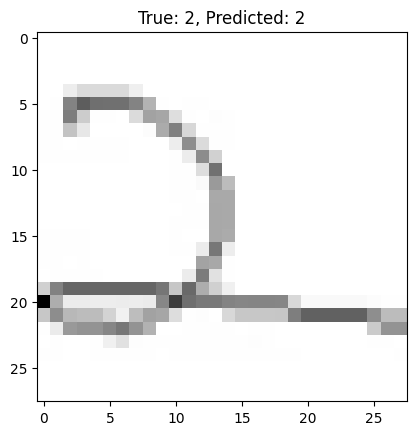

Prediction completed.


In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import csv
import torch.quantization as quant

def save_tensor_to_csv_as_matrix(tensor, filename):
    """
    Save a PyTorch tensor to a CSV file, formatted as matrices for each channel.
    Each matrix represents the spatial dimensions (Height x Width) for a channel,
    with rows separated by commas.

    Parameters:
        tensor (torch.Tensor): The tensor to save (e.g., Batch x Channels x Height x Width).
        filename (str): The name of the CSV file to create.
    """
    # Handle quantized tensors
    if tensor.is_quantized:
        tensor = tensor.int_repr()  # Extract the integer representation

    # Convert the tensor to a NumPy array
    numpy_array = tensor.detach().cpu().numpy()

    # Ensure the tensor has 4 dimensions: [Batch, Channels, Height, Width]
    if len(numpy_array.shape) != 4:
        raise ValueError("Tensor must have 4 dimensions (Batch x Channels x Height x Width).")

    batch_size, num_channels, height, width = numpy_array.shape

    if batch_size != 1:
        raise ValueError("Only batch size of 1 is supported.")

    # Open the file and write matrices for each channel
    with open(filename, mode="w") as file:
        for channel in range(num_channels):
            file.write(f"Channel {channel + 1}:\n")  # Channel header
            for i, row in enumerate(numpy_array[0, channel]):  # Iterate over height (rows)
                file.write(f"{list(row)}")  # Format each row as a list
                if i < height - 1:
                    file.write(",\n")  # Add a comma between rows
                else:
                    file.write("\n")  # No comma after the last row
            file.write("\n")  # Add a newline between channels

    print(f"Tensor saved to {filename} in matrix format.")

class LeNet5(nn.Module):
    def __init__(self, num_classes=34):
        super(LeNet5, self).__init__()
        self.quant = torch.ao.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.print_activation = False  # Add a flag to control printing

    def forward(self, x):
        x = self.quant(x)
        if self.print_activation:
            # print("quant output shape:", x.int_repr())
            save_tensor_to_csv_as_matrix(x, "image_output.csv")
        x = self.conv1(x)
        x = self.relu1(x)
        if self.print_activation:
            # print("Conv1 output shape:", x.int_repr())
            save_tensor_to_csv_as_matrix(x, "relu1_output.csv")
        x = self.pool1(x)
        if self.print_activation:
            # print("Conv1 output shape:", x.int_repr())
            save_tensor_to_csv_as_matrix(x, "pool1_output.csv")
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.reshape(-1, 16 * 5 * 5)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        x = self.dequant(x)
        return x

def load_quantized_model(model_path, num_classes, device):
    # Re-create the float model
    model = LeNet5(num_classes=34)
    model.eval()

    # Set the same QAT configuration as before
    custom_qconfig = quant.QConfig(
        activation=quant.FakeQuantize.with_args(observer=quant.MinMaxObserver, quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine),
        weight=quant.FakeQuantize.with_args(observer=quant.MinMaxObserver, quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric)
    )

    # Apply the custom QConfig to the model
    model.qconfig = custom_qconfig

    # Fuse modules just like during training
    model_fused = torch.ao.quantization.fuse_modules(
        model,
        [['conv1', 'relu1'], ['conv2', 'relu2'], ['fc1', 'relu3'], ['fc2', 'relu4']]
    )

    # Prepare for QAT (simulates the same steps taken during training)
    model_prepared = torch.ao.quantization.prepare_qat(model_fused.train(), inplace=True)

    # Switch to eval mode before feeding dummy data
    model_prepared.eval()

    dummy_input = torch.randn(1, 1, 28, 28).to(device)
    with torch.no_grad():
        _ = model_prepared(dummy_input)  # Populates the observers

    # Now convert the model to quantized form after observers have data
    model_int8 = torch.ao.quantization.convert(model_prepared.eval())

    # Load the saved quantized model weights
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model_int8.load_state_dict(checkpoint['model_state_dict'])

    # Move to device and set to eval mode
    model_int8.to(device)
    model_int8.eval()

    return model_int8


def predict_random_image(model, device, test_loader, int_to_char):
    model.eval()
    model.print_activation = True  # Enable printing before prediction
    print("Starting image prediction...")

    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    random_idx = random.randint(0, images.size(0) - 1)
    image = images[random_idx].unsqueeze(0)
    # print(image)
    true_label = labels[random_idx].item()

    with torch.no_grad():
        output = model(image)
        _, predicted_label = output.max(1)
        predicted_label = predicted_label.item()

    true_char = int_to_char[true_label]
    predicted_char = int_to_char[predicted_label]
    plt.imshow(image.squeeze().cpu().numpy(), cmap="gray")
    plt.title(f"True: {true_char}, Predicted: {predicted_char}")
    plt.show()

    print("Prediction completed.")
    model.print_activation = False  # Disable printing after prediction

# Example usage (ensure you have defined test_loader and dataset.int_to_char):
model_path = "lenetV5.pth"  # Path to your saved quantized model
device = torch.device("cpu")
num_classes = 94

model_int8 = load_quantized_model(model_path, num_classes, device)
predict_random_image(model_int8, device, test_loader, int_to_char)


In [75]:
# Retrieve the weights for the 'conv1' layer
conv1_weights = model_int8.state_dict()['conv1.weight'].int_repr()

# Print weights for each channel with separation
num_channels = conv1_weights.shape[0]  # Number of channels in conv1
for channel in range(num_channels):
    print(f'Channel {channel + 1} weights:')
    print(conv1_weights[channel].view(-1)[:25])  # Print the first 25 weights as an example
    print('-' * 50)  # Separator for clarity


Channel 1 weights:
tensor([  42,   26,  -33,    0,  -15,   28,   18,   34,  -22,  -77,   14,   70,
          20, -103,  -28,  -10,   33,  -22,  -61,   -5,    3,   10,  -33,  -53,
          54], dtype=torch.int8)
--------------------------------------------------
Channel 2 weights:
tensor([-12,  -4, -32,  16, -13, -13,  21,  31,  16,  12,  17,  16,  -9,  12,
         17, -27,  20,  33,  22,  32,  17, -18,   4,  32, -26],
       dtype=torch.int8)
--------------------------------------------------
Channel 3 weights:
tensor([ -15,   32,   55,   70,   68,   26,   35,   86,   58,   35,   42,   43,
          12,   -3,   -6,  -26,  -32,  -55,  -79,  -86,  -49,  -24, -102,  -94,
         -21], dtype=torch.int8)
--------------------------------------------------
Channel 4 weights:
tensor([ -12,  -82, -126, -109,  -53,  -21,  -59,   14,  -27,  -36,   20,   57,
          26,   44,  -13,    5,   64,   60,   49,   10,   35,   25,   30,   28,
          46], dtype=torch.int8)
-------------------------